<a href="https://colab.research.google.com/github/williamm6891/Actividad_1/blob/master/Actividad_2_Redes_Neuronales_Convolucionales_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout



In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 2s 0us/step


In [ ]:
import os

# Ruta del directorio que deseas crear
directory = "/tmp/simpsons"

# Verificar si el directorio ya existe
if not os.path.exists(directory):
    # Crear el directorio si no existe
    os.makedirs(directory)
    print("Directorio creado exitosamente.")
else:
    print("El directorio ya existe.")


Directorio creado exitosamente.


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /tmp/simpsons

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train=X
# X_test=X_t
# y_train=y
# y_test=y_t
# X_train e y_train serán los datos de entrenamiento (80%)
# X_val e y_val serán los datos de validación (20%)


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]

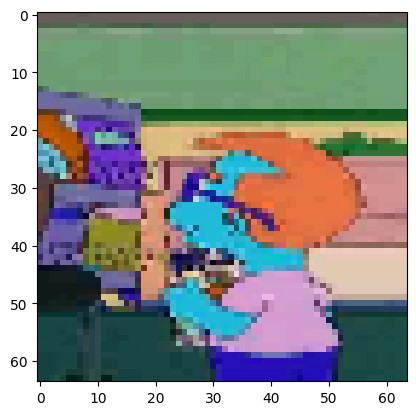

In [ ]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro


## 1. Información sobre el dataset

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

# Preprocesar los datos
X_train  = X_train / 255.0
X_test = X_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train,X_test)
print(y_train,y_test)

[[[[0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   ...
   [0.25490196 0.48235294 0.36862745]
   [0.21960784 0.44705882 0.33333333]
   [0.21960784 0.44705882 0.33333333]]

  [[0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   ...
   [0.22745098 0.45490196 0.34117647]
   [0.21960784 0.44705882 0.33333333]
   [0.21960784 0.44705882 0.33333333]]

  [[0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   [0.74509804 0.53333333 0.27843137]
   ...
   [0.21960784 0.44705882 0.33333333]
   [0.21960784 0.44705882 0.33333333]
   [0.21960784 0.44705882 0.33333333]]

  ...

  [[0.76470588 0.72156863 0.49411765]
   [0.76470588 0.72941176 0.48235294]
   [0.70196078 0.68627451 0.51372549]
   ...
   [0.15294118 0.23137255 0.32941176]
   [0.13333333 0.21176471 0.30980392]
   [0.13333333 0.21176471 0.30980392]]

  [[0.76862745 0.7254902  0.49803922]
   [0.7

In [ ]:
### Tu código aquí ###
# Se obtiene los valores de cantidad de imagen, tamaño de la imagen en X y Y para cada variable y luego se la asigna a una nueva variable para imprimir el resultado.
cant_images_training=X_train.shape[0]
size_x_training=X_train.shape[1]
size_y_training=X_train.shape[2]

cant_images_test=X_test.shape[0]
size_x_test=X_test.shape[1]
size_y_test=X_test.shape[2]

In [ ]:
# De las variables obtenidas se imprime el mensaje a continuación:

print("Cantidad de imagenes training {}. Tamaño de imagenes {}x{}".format(cant_images_training,size_x_training,size_y_training))
print("Cantidad de imagenes test {}. Tamaño de imagenes {}x{}".format(cant_images_test,size_x_test,size_y_test))

Cantidad de imagenes training 15193. Tamaño de imagenes 64x64
Cantidad de imagenes test 3799. Tamaño de imagenes 64x64


## 2. Creación del Modelo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def grafica_hist(history):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()

### Arquitectura 1

In [ ]:
# Definimos el modelo de la red convolucional - 1
model = keras.models.Sequential([
    # Capa de convolución con 32 filtros y tamaño de kernel (3, 3) para extraer características de la imagen.
    # La función de activación 'relu' se utiliza para introducir no linealidad en la salida de la capa.
    # La forma de entrada de la imagen es de tamaño IMG_SIZE x IMG_SIZE x 3 (RGB).
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de convolución con 64 filtros y tamaño de kernel (3, 3).
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de aplanamiento para transformar la salida de la capa anterior en un tensor unidimensional para la entrada de la capa densa.
    keras.layers.Flatten(),
    
    # Capa densa con 128 neuronas y función de activación 'relu' para aprender representaciones no lineales más complejas de las características extraídas por las capas anteriores.
    keras.layers.Dense(units=128, activation='relu'),
    
    # Capa de salida con tantas neuronas como personajes se quieren clasificar (MAP_CHARACTERS) y función de activación 'softmax', que produce una distribución de probabilidad sobre las clases de salida.
    keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])


# Compilamos el modelo con optimizador adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train,y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
475/475 [==============================] - 15s 9ms/step - loss: 1.9271 - accuracy: 0.4266 - val_loss: 1.4785 - val_accuracy: 0.5636
Epoch 2/20
475/475 [==============================] - 3s 6ms/step - loss: 1.1616 - accuracy: 0.6602 - val_loss: 1.1315 - val_accuracy: 0.6733
Epoch 3/20
475/475 [==============================] - 3s 6ms/step - loss: 0.7909 - accuracy: 0.7694 - val_loss: 0.9977 - val_accuracy: 0.7076
Epoch 4/20
475/475 [==============================] - 3s 6ms/step - loss: 0.5182 - accuracy: 0.8472 - val_loss: 0.9154 - val_accuracy: 0.7515
Epoch 5/20
475/475 [==============================] - 3s 7ms/step - loss: 0.3245 - accuracy: 0.9059 - val_loss: 0.9765 - val_accuracy: 0.7431
Epoch 6/20
475/475 [==============================] - 3s 6ms/step - loss: 0.1943 - accuracy: 0.9430 - val_loss: 1.0695 - val_accuracy: 0.7507
Epoch 7/20
475/475 [==============================] - 3s 6ms/step - loss: 0.1139 - accuracy: 0.9674 - val_loss: 1.1894 - val_accuracy: 0.7449
Epoch

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
# se evalua el modelo con los datos de test y se muestra información detallada de la evaluación.
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

# se imprime el accuray de 0.86 inferior al accuray del entrenamiento, que quiere decir que existe overfitting con el nuevo dataset
print('Test accuracy - arq1:{}'.format(test_acc))

119/119 [==============================] - 0s 4ms/step - loss: 1.8645 - accuracy: 0.7449
Test accuracy - arq1:0.7449328899383545


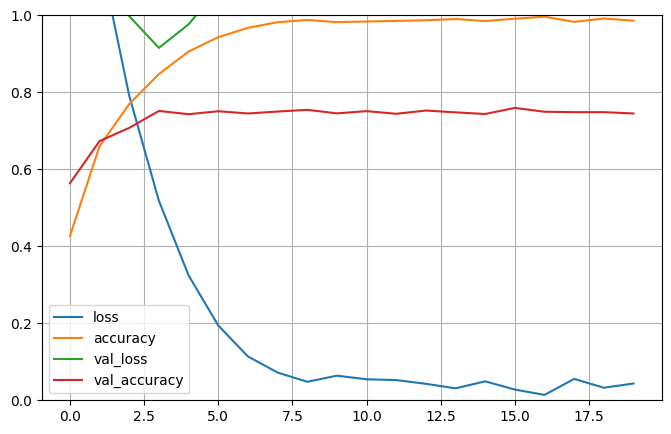

In [ ]:
# Graficar accuracy (train,test) y loss (train,test) de la primera arquitectura
grafica_hist(history)

### Arquitectura 2 - Regularización Dropout

In [ ]:
# Definimos el modelo de la red convolucional - 2
model2 = keras.models.Sequential([
    # Capa de convolución con 32 filtros y tamaño de kernel (3, 3) para extraer características de la imagen.
    # La función de activación 'relu' se utiliza para introducir no linealidad en la salida de la capa.
    # La forma de entrada de la imagen es de tamaño IMG_SIZE x IMG_SIZE x 3 (RGB).
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de convolución con 64 filtros y tamaño de kernel (3, 3).
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de aplanamiento para transformar la salida de la capa anterior en un tensor unidimensional para la entrada de la capa densa.
    keras.layers.Flatten(),
    
    # Capa densa con 128 neuronas y función de activación 'relu' para aprender representaciones no lineales más complejas de las características extraídas por las capas anteriores.
    keras.layers.Dense(units=128, activation='relu'),

    # Capa Dropout para regularización.
    keras.layers.Dropout(0.5),
    
    # Capa de salida con tantas neuronas como personajes se quieren clasificar (MAP_CHARACTERS) y función de activación 'softmax', que produce una distribución de probabilidad sobre las clases de salida.
    keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
# Compilamos el modelo con optimizador adam
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train,y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
475/475 [==============================] - 5s 8ms/step - loss: 2.2680 - accuracy: 0.3047 - val_loss: 1.6437 - val_accuracy: 0.5330
Epoch 2/20
475/475 [==============================] - 3s 6ms/step - loss: 1.6102 - accuracy: 0.5151 - val_loss: 1.2141 - val_accuracy: 0.6560
Epoch 3/20
475/475 [==============================] - 4s 8ms/step - loss: 1.2672 - accuracy: 0.6119 - val_loss: 1.0452 - val_accuracy: 0.7012
Epoch 4/20
475/475 [==============================] - 3s 7ms/step - loss: 1.0182 - accuracy: 0.6883 - val_loss: 0.8782 - val_accuracy: 0.7494
Epoch 5/20
475/475 [==============================] - 3s 6ms/step - loss: 0.8402 - accuracy: 0.7356 - val_loss: 0.8502 - val_accuracy: 0.7470
Epoch 6/20
475/475 [==============================] - 3s 6ms/step - loss: 0.7098 - accuracy: 0.7713 - val_loss: 0.7699 - val_accuracy: 0.7781
Epoch 7/20
475/475 [==============================] - 4s 7ms/step - loss: 0.6023 - accuracy: 0.8058 - val_loss: 0.7483 - val_accuracy: 0.7855
Epoch 

In [ ]:
# se evalua el modelo con los datos de test y se muestra información detallada de la evaluación.
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=1)

# se imprime el accuray de 0.86 inferior al accuray del entrenamiento, que quiere decir que existe overfitting con el nuevo dataset
print('Test accuracy - arq2:{}'.format(test_acc))

119/119 [==============================] - 1s 6ms/step - loss: 0.9524 - accuracy: 0.8123
Test accuracy - arq2:0.8123190402984619


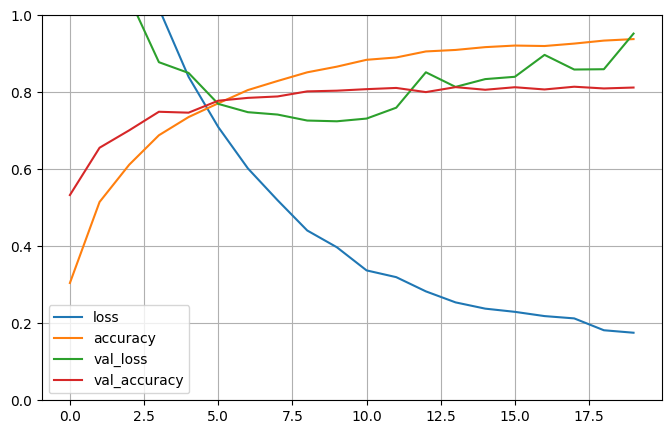

In [ ]:
# Graficar accuracy (train,test) y loss (train,test) de la primera arquitectura
grafica_hist(history2)

### Arquitectura 3 - BatchNormalization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
model3 = keras.models.Sequential([
    # Capa de convolución con 32 filtros y tamaño de kernel (3, 3) para extraer características de la imagen.
    # La función de activación 'relu' se utiliza para introducir no linealidad en la salida de la capa.
    # La forma de entrada de la imagen es de tamaño IMG_SIZE x IMG_SIZE x 3 (RGB).
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
	  BatchNormalization(),
	
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de convolución con 64 filtros y tamaño de kernel (3, 3).
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
	  BatchNormalization(),
    
    # Capa de MaxPooling2D para reducir la dimensionalidad de la salida de la capa de convolución anterior. 
    # El tamaño de la ventana de pooling es (2,2), lo que reduce la resolución de la imagen a la mitad.
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
	
	  # Capa de convolución con 128 filtros y tamaño de kernel (3, 3).
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
	  BatchNormalization(),
	  keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Capa de aplanamiento para transformar la salida de la capa anterior en un tensor unidimensional para la entrada de la capa densa.
    keras.layers.Flatten(),
    
    # Capa densa con 512 neuronas y función de activación 'relu' para aprender representaciones no lineales más complejas de las características extraídas por las capas anteriores.
    keras.layers.Dense(units=512, activation='relu'),

    # Capa Dropout para regularización.
    keras.layers.Dropout(0.5),
    
    # Capa de salida con tantas neuronas como personajes se quieren clasificar (MAP_CHARACTERS) y función de activación 'softmax', que produce una distribución de probabilidad sobre las clases de salida.
    keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])



In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
# Compilación del modelo
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(X_train,y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
475/475 [==============================] - 9s 12ms/step - loss: 2.1496 - accuracy: 0.4116 - val_loss: 1.5797 - val_accuracy: 0.5249
Epoch 2/20
475/475 [==============================] - 4s 8ms/step - loss: 1.3146 - accuracy: 0.6120 - val_loss: 1.2688 - val_accuracy: 0.6349
Epoch 3/20
475/475 [==============================] - 4s 9ms/step - loss: 0.9296 - accuracy: 0.7195 - val_loss: 0.7698 - val_accuracy: 0.7663
Epoch 4/20
475/475 [==============================] - 4s 9ms/step - loss: 0.6697 - accuracy: 0.7999 - val_loss: 0.7529 - val_accuracy: 0.7836
Epoch 5/20
475/475 [==============================] - 4s 9ms/step - loss: 0.4878 - accuracy: 0.8524 - val_loss: 0.6583 - val_accuracy: 0.8228
Epoch 6/20
475/475 [==============================] - 5s 10ms/step - loss: 0.3859 - accuracy: 0.8824 - val_loss: 0.5885 - val_accuracy: 0.8376
Epoch 7/20
475/475 [==============================] - 4s 9ms/step - loss: 0.3006 - accuracy: 0.9082 - val_loss: 0.6443 - val_accuracy: 0.8221
Epoc

In [ ]:
# se evalua el modelo con los datos de test y se muestra información detallada de la evaluación.
test_loss, test_acc = model3.evaluate(X_test,  y_test, verbose=1)

# se imprime el accuray de 0.86 inferior al accuray del entrenamiento, que quiere decir que existe overfitting con el nuevo dataset
print('Test accuracy - arq3:{}'.format(test_acc))

119/119 [==============================] - 1s 4ms/step - loss: 0.9441 - accuracy: 0.8531
Test accuracy - arq3:0.8531192541122437


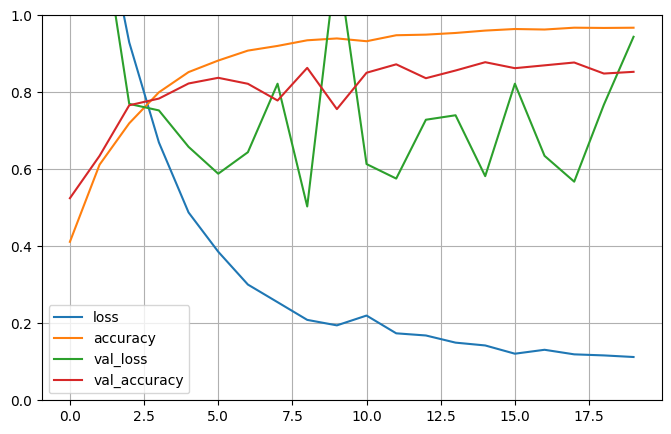

In [ ]:
# Graficar accuracy (train,test) y loss (train,test) de la primera arquitectura
grafica_hist(history3)

### Arquirectura 4 - Data Augmentation

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# Cargamos los datos de entrenamiento con ImageDataGenerator
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)

training_datagen.fit(X)

# Definimos la arquitectura de la red neuronal
model4 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])



datagen_train=training_datagen.flow(X,keras.utils.to_categorical(y,len(MAP_CHARACTERS)),batch_size=32,subset='training')
datagen_test=training_datagen.flow(X,keras.utils.to_categorical(y,len(MAP_CHARACTERS)),batch_size=32,subset='validation')

In [ ]:
# Compilamos el modelo
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history4 = model4.fit(
    datagen_train,
    epochs = 20,
    validation_data = datagen_test,
    verbose = 2)

Epoch 1/20
475/475 - 26s - loss: 2.3126 - accuracy: 0.2862 - val_loss: 1.9268 - val_accuracy: 0.4018 - 26s/epoch - 56ms/step
Epoch 2/20
475/475 - 24s - loss: 1.6313 - accuracy: 0.5021 - val_loss: 1.4010 - val_accuracy: 0.5840 - 24s/epoch - 50ms/step
Epoch 3/20
475/475 - 25s - loss: 1.2869 - accuracy: 0.6039 - val_loss: 1.1141 - val_accuracy: 0.6638 - 25s/epoch - 52ms/step
Epoch 4/20
475/475 - 24s - loss: 1.0657 - accuracy: 0.6716 - val_loss: 1.0605 - val_accuracy: 0.6848 - 24s/epoch - 50ms/step
Epoch 5/20
475/475 - 24s - loss: 0.9287 - accuracy: 0.7165 - val_loss: 0.8871 - val_accuracy: 0.7372 - 24s/epoch - 50ms/step
Epoch 6/20
475/475 - 24s - loss: 0.8320 - accuracy: 0.7476 - val_loss: 0.8003 - val_accuracy: 0.7591 - 24s/epoch - 50ms/step
Epoch 7/20
475/475 - 24s - loss: 0.7656 - accuracy: 0.7655 - val_loss: 0.7233 - val_accuracy: 0.7804 - 24s/epoch - 50ms/step
Epoch 8/20
475/475 - 24s - loss: 0.7171 - accuracy: 0.7822 - val_loss: 0.6657 - val_accuracy: 0.8012 - 24s/epoch - 50ms/step


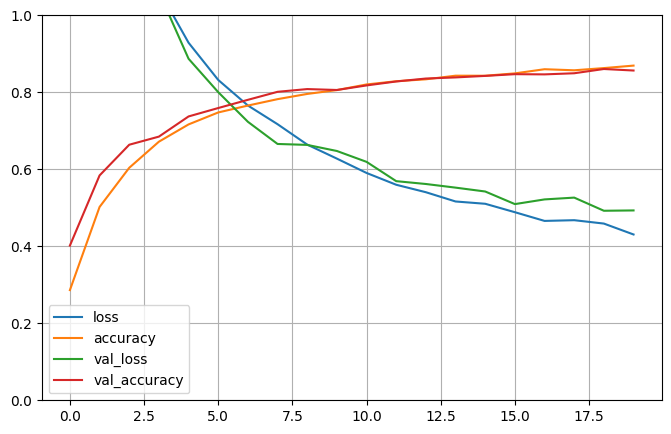

In [ ]:
# Graficar accuracy (train,test) y loss (train,test) de la primera arquitectura
grafica_hist(history4)

### Compara modelos CNN y un modelo Fully Connected

In [ ]:
#!pip install Keras-Preprocessing

In [ ]:
# Definición del modelo FC
model_fc = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # Capa de entrada para imágenes de IMG_SIZExIMG_SIZE
    keras.layers.Dense(32, activation='relu'),  # Capa oculta con 32 neuronas y función de activación ReLU
    keras.layers.Dense(64, activation='relu'),  # Capa oculta con 64 neuronas y función de activación ReLU
    keras.layers.Dense(128, activation='relu'),  # Capa oculta con 128 neuronas y función de activación ReLU
    keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')  # Capa de salida con 18 neuronas (1 por cada categoría) y función de activación Softmax
])

# # Compilación del modelo
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# Compilar y entrenar la arquitectura Fully Connected
model_fc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_fc = model_fc.fit(datagen_train,epochs=20, validation_data=datagen_test,verbose = 2)
# history4 = model4.fit(
#     datagen_train,
#     epochs = 20,
#     validation_data = datagen_test,
#     verbose = 2)
# history_fc = model_fc.fit(datagen_train,epochs = 20,validation_data = datagen_test,verbose = 2)
# history_fc = model_fc.fit(datagen_train,y_train, epochs=20)
# history_fc = model_fc.fit(X_train,y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
475/475 - 26s - loss: 2.8185 - accuracy: 0.1135 - val_loss: 2.7897 - val_accuracy: 0.1274 - 26s/epoch - 55ms/step
Epoch 2/20
475/475 - 24s - loss: 2.7996 - accuracy: 0.1160 - val_loss: 2.7877 - val_accuracy: 0.1274 - 24s/epoch - 52ms/step
Epoch 3/20
475/475 - 26s - loss: 2.7993 - accuracy: 0.1160 - val_loss: 2.7880 - val_accuracy: 0.1274 - 26s/epoch - 55ms/step
Epoch 4/20
475/475 - 24s - loss: 2.7989 - accuracy: 0.1160 - val_loss: 2.7870 - val_accuracy: 0.1274 - 24s/epoch - 51ms/step
Epoch 5/20
475/475 - 25s - loss: 2.7990 - accuracy: 0.1160 - val_loss: 2.7891 - val_accuracy: 0.1274 - 25s/epoch - 52ms/step
Epoch 6/20
475/475 - 24s - loss: 2.7984 - accuracy: 0.1160 - val_loss: 2.7897 - val_accuracy: 0.1274 - 24s/epoch - 51ms/step
Epoch 7/20
475/475 - 24s - loss: 2.7988 - accuracy: 0.1160 - val_loss: 2.7872 - val_accuracy: 0.1274 - 24s/epoch - 51ms/step
Epoch 8/20
475/475 - 24s - loss: 2.7988 - accuracy: 0.1160 - val_loss: 2.7878 - val_accuracy: 0.1274 - 24s/epoch - 51ms/step


In [ ]:
# Evaluar los modelos
test_loss_cnn, test_acc_cnn = model4.evaluate(datagen_test, steps=20)
test_loss_fc, test_acc_fc = model_fc.evaluate(datagen_test, steps=20)

print("CNN: Loss={}, Accuracy={}".format(test_loss_cnn, test_acc_cnn))
print("Fully Connected: Loss={}, Accuracy={}".format(test_loss_fc, test_acc_fc))

20/20 [==============================] - 1s 41ms/step - loss: 2.7858 - accuracy: 0.1234
CNN: Loss=0.5147395730018616, Accuracy=0.846875011920929
Fully Connected: Loss=2.78580904006958, Accuracy=0.12343750149011612


### Reporte de clasificación

Se verifica La primera imagen del dataset de Test

Se crea la función **plot_confusion_matrix** para darle un estilo a la matriz de confusión generada. 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Se crea el reporte de clasificación con las distintas métricas de rendimiento (Precision, Recall, F1_Score). 

119/119 [==============================] - 0s 3ms/step

                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.88      0.88      0.88       172
  apu_nahasapeemapetilon       0.92      0.98      0.95       134
            bart_simpson       0.88      0.76      0.81       304
charles_montgomery_burns       0.88      0.75      0.81       231
            chief_wiggum       0.96      0.90      0.93       173
          comic_book_guy       0.76      0.77      0.76        96
          edna_krabappel       0.87      0.88      0.88        93
           homer_simpson       0.78      0.93      0.85       437
           kent_brockman       0.97      0.81      0.89        96
        krusty_the_clown       0.83      0.97      0.90       246
            lisa_simpson       0.77      0.80      0.78       275
           marge_simpson       0.93      0.94      0.93       260
     milhouse_van_houten       0.91      0.93      0.92       203
             moe_s

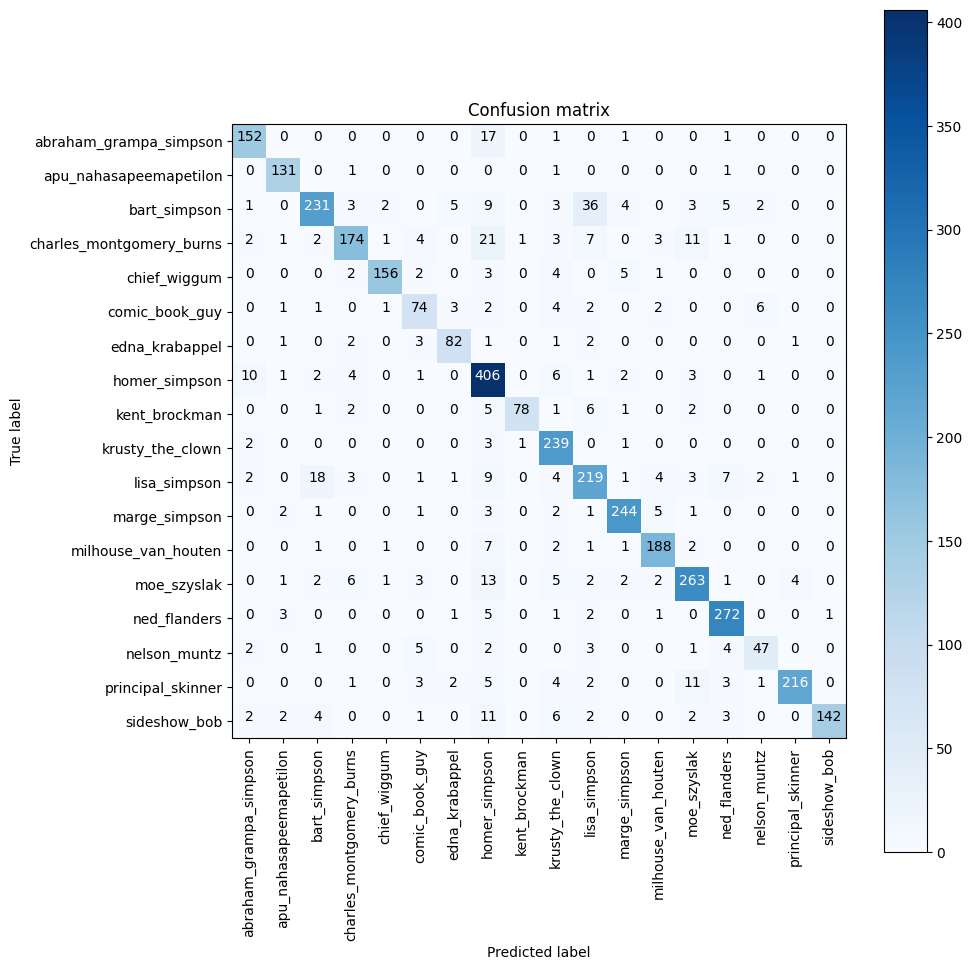

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix,classification_report

# Obtener las predicciones del modelo

Y_pred = model4.predict(X_test)
#Y_pred = model4.predict(X_test_2)

target_names = list(MAP_CHARACTERS.values())
y_pred_classes = np.argmax(Y_pred,axis = 1)

y_true = np.argmax(y_test,axis = 1)
#y_true = np.argmax(y_test_2,axis = 1)

print('\n',classification_report(y_true,y_pred_classes, target_names=target_names))
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = target_names) 





Como se puede observar, el reporte de clasificación arroja un accuracy en la predicción del 87%. Según la métrica F1_Score, la cual combina las medidas de precision y recall en un solo valor, podemos también verificar que para esta arquitectura del modelo4 con data augmentation y para este conjunto de datos de prueba, la clase **comic_book_guy** y **nelson_muntz** resultan las mas dificiles de clasificar. Para varias clases como **apu_nahasapeemapetilon       ** y **marge_simpson** se obtienen mejores resultados. En general el modelo con esta arquitectura suele arrojar muy buenos resultados en la clasificación.

In [ ]:
MAP_CHARACTERS

{0: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 2: 'bart_simpson',
 3: 'charles_montgomery_burns',
 4: 'chief_wiggum',
 5: 'comic_book_guy',
 6: 'edna_krabappel',
 7: 'homer_simpson',
 8: 'kent_brockman',
 9: 'krusty_the_clown',
 10: 'lisa_simpson',
 11: 'marge_simpson',
 12: 'milhouse_van_houten',
 13: 'moe_szyslak',
 14: 'ned_flanders',
 15: 'nelson_muntz',
 16: 'principal_skinner',
 17: 'sideshow_bob'}

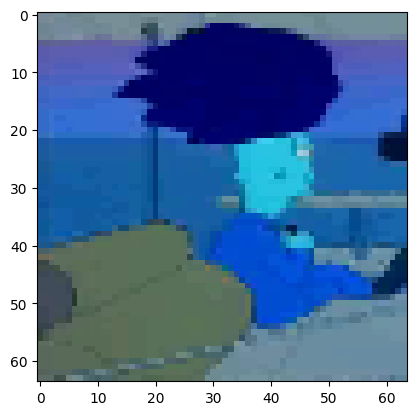

In [ ]:
plt.imshow(X_test[0])

Se compara la imagen en esta posición con la clase predicha.

In [ ]:
y_pred_classes[0]

17

In [ ]:
y_true[0]

17

Como podemos observar, coniciden las etiquetas. En este caso la numero **17** corresponde a la de **sideshow_bob**

### Análisis visual de errores

In [ ]:
import matplotlib.pyplot as plt

# Obtener las predicciones de la red para el conjunto de test
y_pred = model4.predict(datagen_test)

# Convertir las predicciones de vuelta a etiquetas
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas reales del conjunto de test
y_true = datagen_test.classes

# Obtener las imágenes mal clasificadas
misclassified_idx = np.where(y_pred_labels != y_true)[0]

# Elegir algunas de las imágenes mal clasificadas para mostrar
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(IMG_SIZE, IMG_SIZE))
for i in range(num_images):
    idx = misclassified_idx[i]
    img = datagen_test[idx][0][0]
    label = class_names[y_true[idx]]
    pred = class_names[y_pred_labels[idx]]
    axes[i].imshow(img)
    axes[i].set_title(f"Real: {label}\nPredicción: {pred}")


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.